# Assignment 2: Fourier Analysis

## 0: Introduction

The following is adapted from chapter 12 of Numerical recipes, which may be reviewed if you would like a more complete introduction.

Imagine we have a process descibed as a function of time, $g(t)$. We say that this process is described in the _time domain_. We may also describe this process in the frequency domain, where the process is described by a specific amplitude $\tilde{g}(f)$. We can go back and forth between representations using Fourier transforms,

$$
\begin{align}
\tilde{g}(f) &= \int_{-\infty}^\infty g(t) e^{2\pi i f t}dt\\
g(t) &= \int_{-\infty}^{\infty} \tilde{g}(f) e^{-2\pi i f t}dt.
\end{align}
$$

In many physics applications, we perform Fourier transformations between position and momentum domains.

### Discrete Fourier Transforms

Consider a periodic function $h$, $h(x) = h(x+L)$ from some period $L$. We may represent this function as a Fourier series 

$$
h(x) = \sum_{k=-\infty}^{\infty} \tilde{h}_k e^{-2\pi i f_k x}, f_k = k/L.
$$

The Fourier coefficients $\tilde{h}_k$ may be recovered using the Fourier transform equation above.

We can map a set of $N$ time-domain values $h_i$ onto a set of $N$ frequency-domain functions by the transformation

$$
\tilde{h}_k = \frac{1}{N} \sum_{i=0}^{N-1} h_j e^{2\pi i f_k x_j},
$$

where $x_j = jL/N$ and $f_k = k/L$.


### FFTs

The Fast Fourier Transform (FFT) reduce the compute time from $O(N^2)$ to $O(N \log N)$, making them a lot more accessible for a variety of computations. Scipy has an implementation of FFT that we can make use of.

### PSDs

Parseval's theorem tells us that the total power of a signal is the same regardless of which domain we compute it in,

$$
\texttt{total power} = \int |g(t)|^2 dt = \int |\tilde{g}(f)|^2 dt.
$$

Often, one wants to compute how much power is contained in the interval $[f, f+df]$. We then regard the frequency as varying from $0$ to $\infty$ and define the one-sided power spectral density (PSD)

$$
P_g(f) = |\tilde{g}(f)|^2 + |\tilde{g}(-f)|^2 .
$$

### SNR

The signal-to-noise ratio compares the level of the desired signal to the level of the background noise.

## 1: SETI signals

SETI (Search for Extra Terrestrial Intelligence) analyzes signals collected from telescopes for messages from extraterrestrial civilizations. We are providing you with a ficticious time series of $32768$ elements sampled at intervals of 1 ms, representing the output of a telescope in Arecibo, Puerto Rico. 

#### (1) Import and plot the data as a function of time. Does it reveal in obvious features? 

In [ ]:
## insert code here

# read the file arecibo1.txt
with open('arecibo1.txt', 'r') as f:
    arecibo1 = f.read()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [21]:
data = np.loadtxt('arecibo1.txt')
time = np.arange(0, len(data) * 0.001, 0.001)

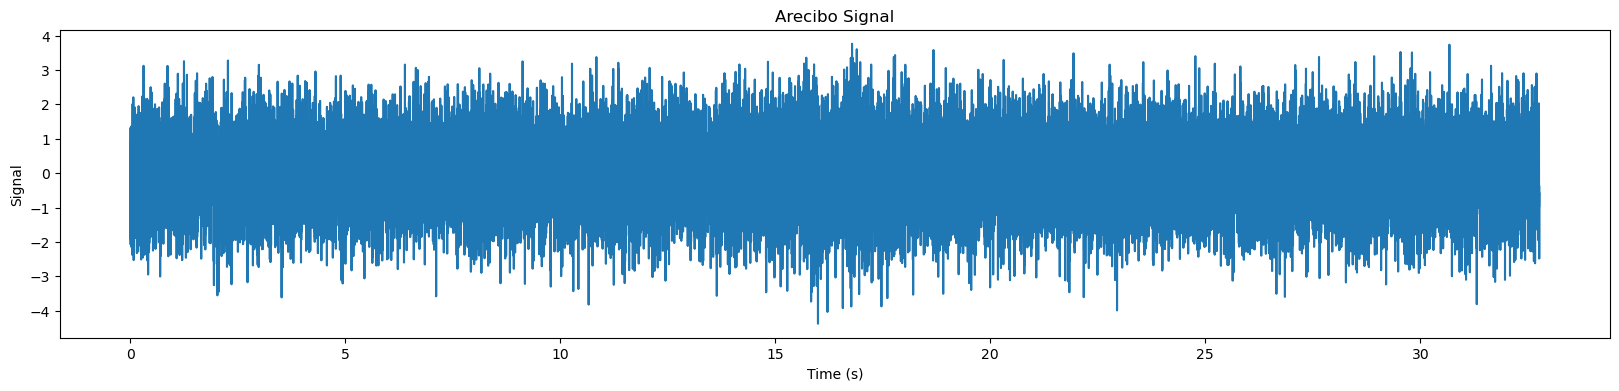

In [11]:
plt.figure(figsize=(20, 4))
plt.plot(time, data)
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Arecibo Signal')
plt.show()

This data actually has a roughly definite frequency, it is just difficult to see in the time domain. If we perform an FFT, the power will be reassembled into a few nearby Fourier coefficients.

#### (2) Perform the FFT and plot the result. Identify the frequency in Hertz (taking the point where the magnitude of the FFT is maximal to be the frequency).

/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


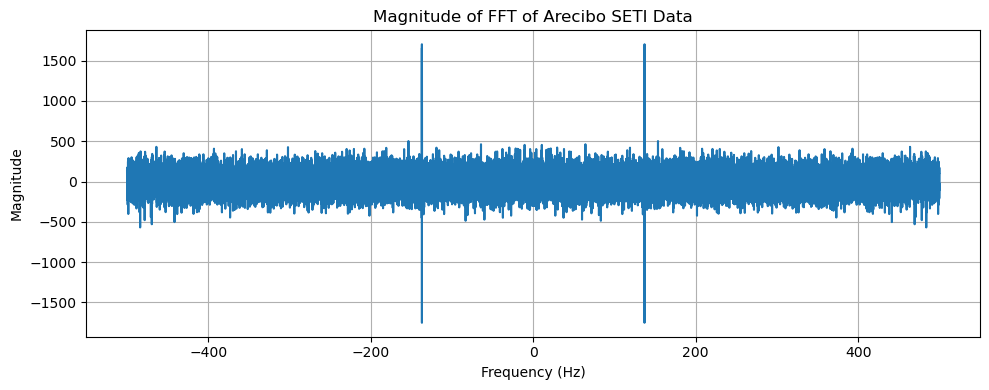

In [19]:
## FFT

N = len(data)
dt = 0.001 
Fs = 1/dt  # sampling frequency in Hz

fft_data = np.fft.fft(data)
freqs = np.fft.fftfreq(N, dt)

positive_freqs = freqs[:N//2]
positive_fft = fft_data[:N//2]

# plot the magnitude of the FFT.
plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_data,  lw=1.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude of FFT of Arecibo SETI Data')
plt.grid(True)
plt.tight_layout()
plt.show()

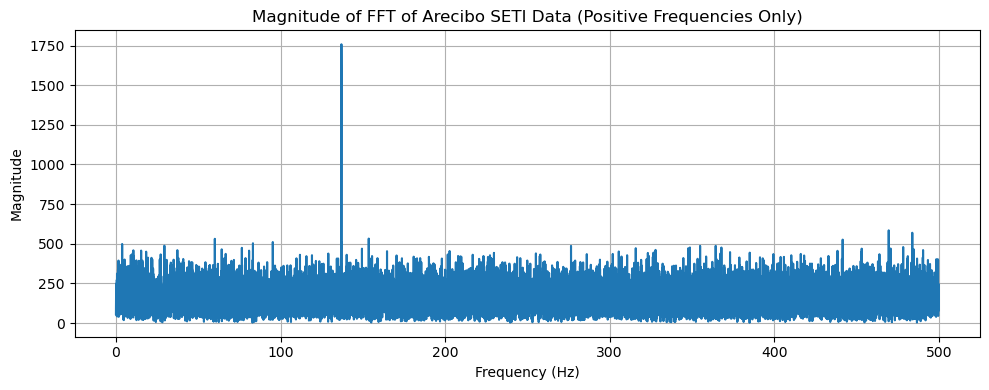

In [17]:
# only plot the positive frequencies because of the symmetry
plt.figure(figsize=(10, 4))
plt.plot(positive_freqs, np.abs(positive_fft), lw=1.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude of FFT of Arecibo SETI Data (Positive Frequencies Only)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
max_index = np.argmax(np.abs(positive_fft))
dominant_frequency = positive_freqs[max_index]
print("Dominant frequency: {:.3f} Hz".format(dominant_frequency))

Dominant frequency: 136.993 Hz


#### (3) Zero out the non-significant entries from the Fourier transform. Perform an inverse Fourier transform and plot the results. What do you notice?

In [36]:
# Your code here

# threshold = ? of the maximum value
threshold = 0.50 * np.max(np.abs(fft_data))
fft_filtered = fft_data.copy()
fft_filtered[np.abs(fft_filtered) < threshold] = 0

data_filtered = np.fft.ifft(fft_filtered)
data_filtered = np.real(data_filtered)

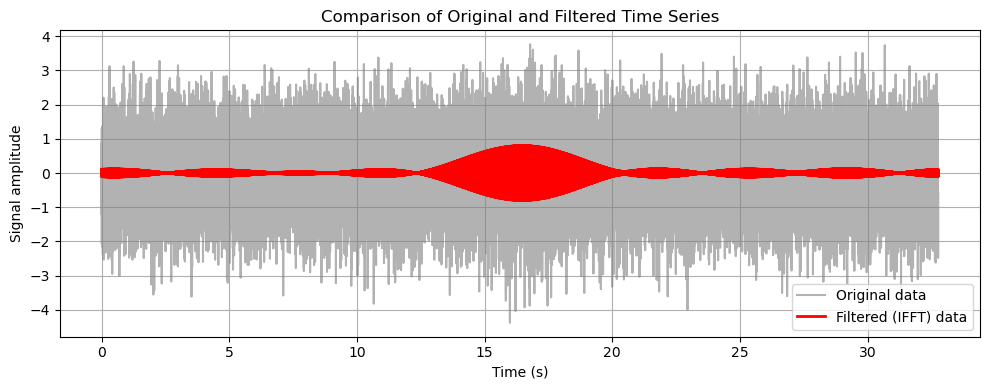

In [37]:
plt.figure(figsize=(10, 4))
plt.plot(time, data, label='Original data', color='gray', alpha=0.6)
plt.plot(time, data_filtered, label='Filtered (IFFT) data', color='red', lw=2)
plt.xlabel('Time (s)')
plt.ylabel('Signal amplitude')
plt.title('Comparison of Original and Filtered Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Answer:** 
After filtering out insignificant data (less than 0.6 of the maximum), the noise is greatly reduced, and thus we see a periodic trend with period about 5s.

## 2: Some noisy (literally) data

We have some data (in the attached wav file) that has been captured from a noisy room. It sounds, and looks like, there may be no distinct frequency. However, Fourier/spectral techniques may reveal otherwise. 

#### (4) Make use of scipy's io functions to read in and plot the data in the included wav file. Add a sine wave to the data of the given form and plot the signal (our generated sine wave), the recorded noise, and the total on the same time series plot.

In this step, we are injecting a 'true signal' into our data, to make the subsequent frequency analysis a bit clearer. Pick an amplitude, frequency, and phase, and add it to the noise from the wav file.

In [38]:
# Your code here
from scipy.io import wavfile

sample_rate, noise_data = wavfile.read('crowd-talking-1.wav')

In [39]:
noise_data.ndim

2

In [40]:
if noise_data.ndim > 1:
    noise_data = noise_data[:, 0]

In [41]:
t = np.linspace(0, len(noise_data) / sample_rate, num=len(noise_data), endpoint=False)

In [54]:
amplitude = 0.5 * np.max(np.abs(noise_data))  
frequency = 440
phase = 0 

sine_wave = amplitude * np.sin(2 * np.pi * frequency * t + phase)

In [55]:
combined_signal = noise_data + sine_wave

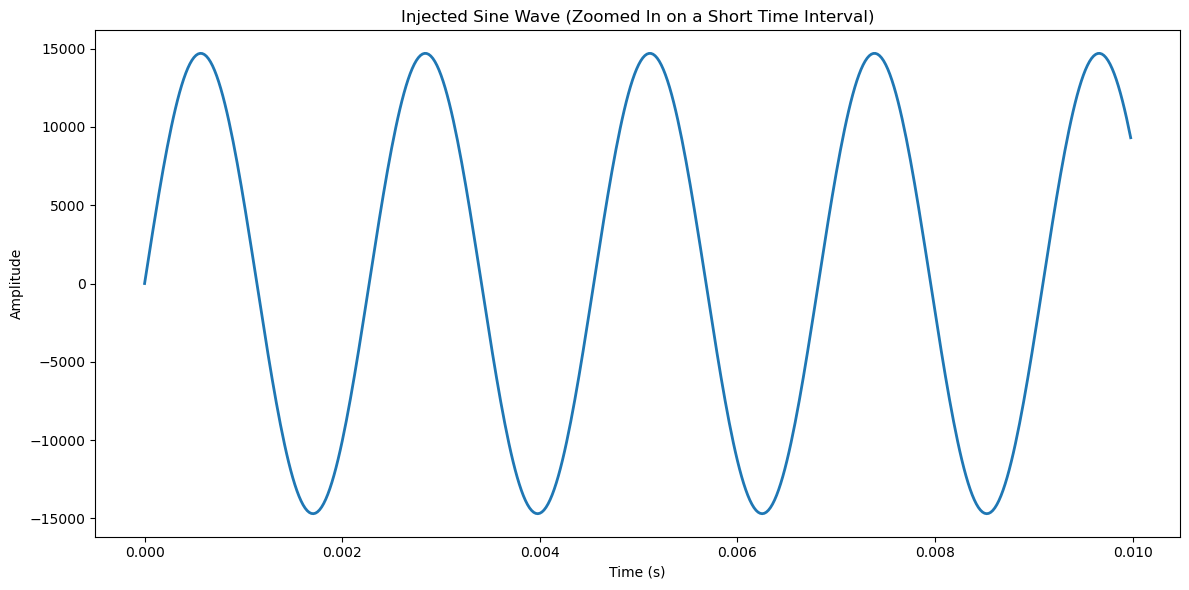

In [61]:
mask = t < 0.01
t_zoom = t[mask]
sine_zoom = sine_wave[mask]

plt.figure(figsize=(12, 6))
plt.plot(t_zoom, sine_zoom, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Injected Sine Wave (Zoomed In on a Short Time Interval)')
plt.tight_layout()
plt.show()

/var/folders/bt/8lz5hj4d0fbbslj5lj4c85qm0000gn/T/ipykernel_57694/1985864819.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


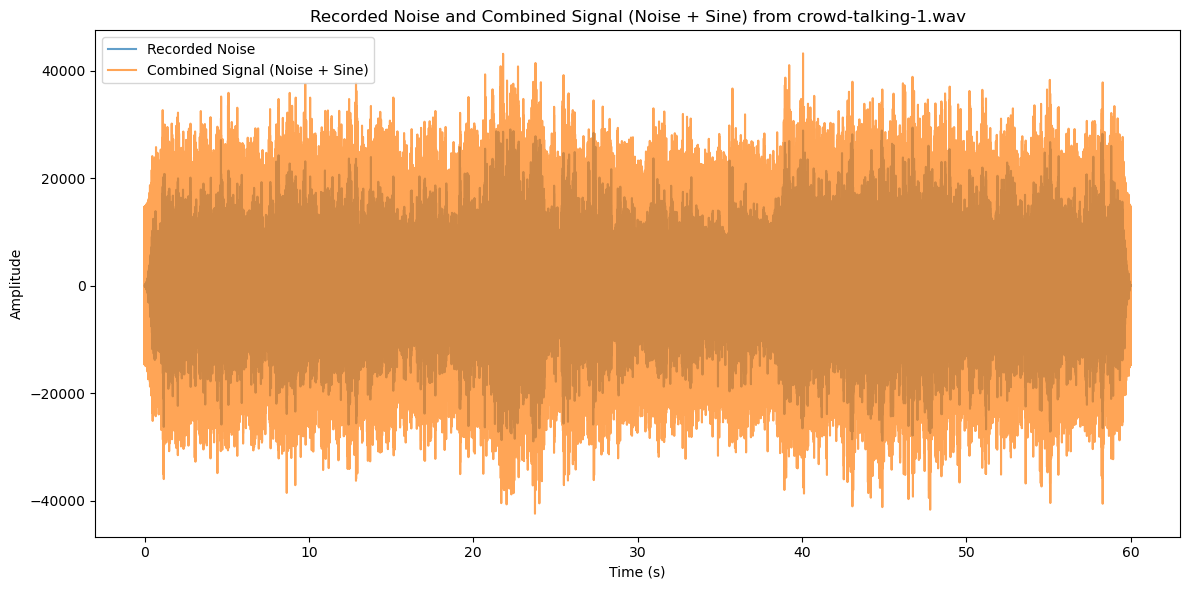

In [60]:
plt.figure(figsize=(12, 6))
# plt.plot(t, sine_wave, label='Injected Sine Wave', color='black', linewidth=2)
plt.plot(t, noise_data, label='Recorded Noise', alpha=0.7)
plt.plot(t, combined_signal, label='Combined Signal (Noise + Sine)', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Recorded Noise and Combined Signal (Noise + Sine) from crowd-talking-1.wav')
plt.legend()
plt.tight_layout()
plt.show()

#### (5) Welch's method can be used to perform spectral density estimation. 

* Use scipy's implementation of Welch's method to compute and plot a PSD for the noisy data.
* Do you have any observations about the shape of the data?

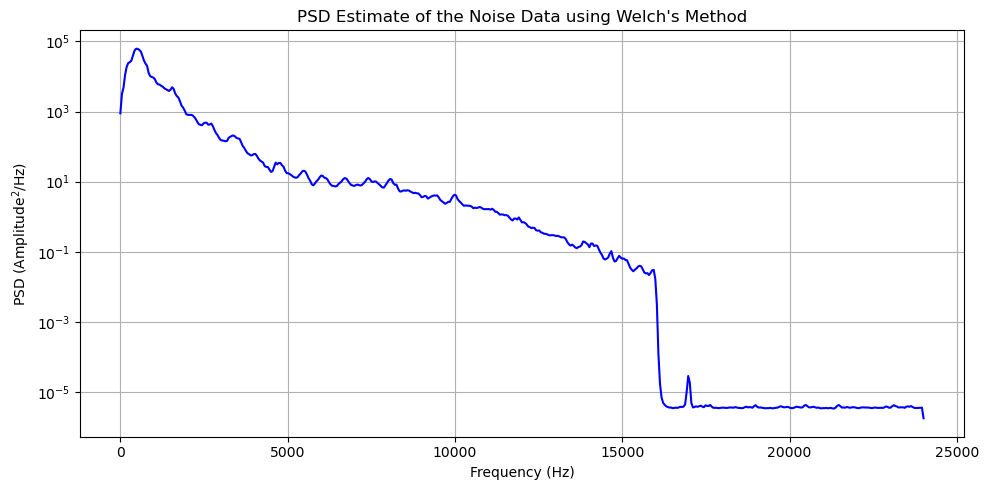

In [53]:
# your code here
from scipy.signal import welch

f, Pxx = welch(noise_data, fs=sample_rate, nperseg=1024)

plt.figure(figsize=(10, 5))
plt.semilogy(f, Pxx, color='blue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (Amplitude$^2$/Hz)')
plt.title("PSD Estimate of the Noise Data using Welch's Method")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:** The amplitude rises to the peak at 800 Hz, then going stably down. There is a sudden drop at frequency around 16.5 kHz. After that, the amplitude is almost constant. 

#### (6) Now compare the PSDs of the 2 quantities: the noise, and the noise with the sine wave. The frequency resolution of the PSD is inversely proportional to the length of the FFT. Use the 'nperseg' quantity to adjust the FFT length until the injected signal is easily visible in the plot.

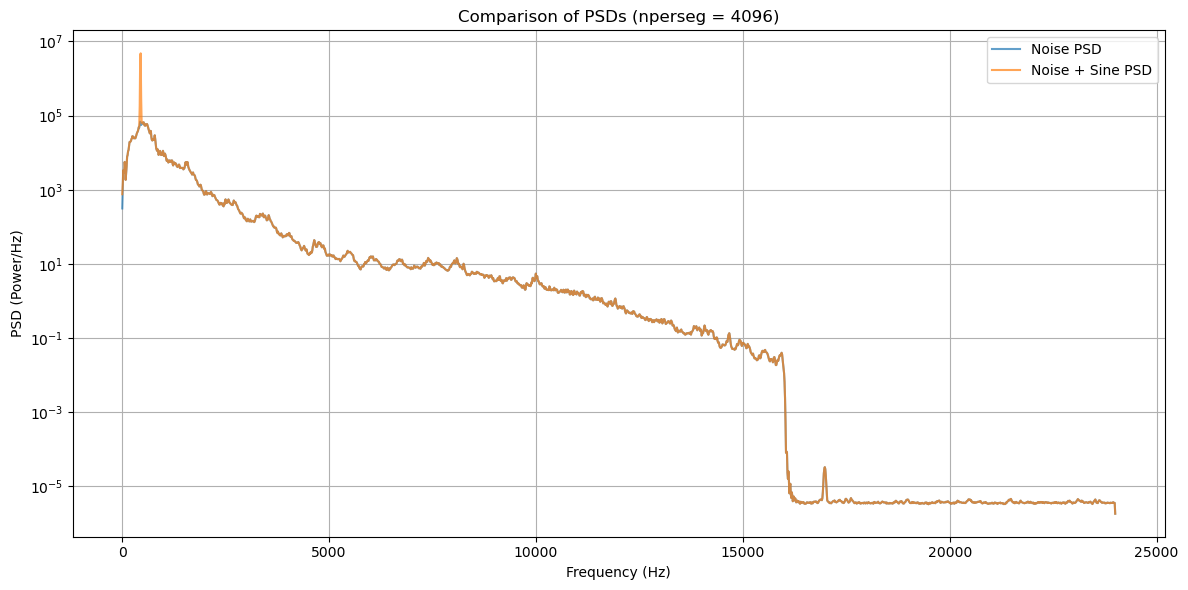

In [ ]:
# Your code here

nperseg = 4096  

# PSD of the original noise.
frequencies_noise, psd_noise = welch(noise_data, fs=sample_rate, nperseg=nperseg)

# PSD of the noise + injected sine wave.
frequencies_combined, psd_combined = welch(combined_signal, fs=sample_rate, nperseg=nperseg)

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies_noise, psd_noise, label='Noise PSD', alpha=0.7)
plt.semilogy(frequencies_combined, psd_combined, label='Noise + Sine PSD', alpha=0.7)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (Power/Hz)')
plt.title(f'Comparison of PSDs (nperseg = {nperseg})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:** we can see a clear peak for combined signal at 440 Hz (the frequency of sine wave).

#### Let's say we are trying to estimate the amplitude and frequency of this sine wave. How might we do it?

One familiar technique is fitting. However, in this case the signal is much smaller than the noise, so directly fitting the data would not converge with any accuracy or precision.

Given a model for the signal that it has a frequency "near" f_sig, we can use the following recipe, which is known as 'heterodyne detection':

$$z_{estimate} = \int_{t_0}^{t_1} data(t) * LO(t) dt$$

where $$LO(t) = e^{i \omega t}$$

this is essentially a single frequency Fourier Transform. By averaging over a sufficiently long time, all of the contributions from frequencies other than $f_{sig}$ will disappear.

In Python, we can implement this performing a "moving average" on the integrand. The output, (smoothed(z_estimate)), will give a running estimate of the cosine and sine components of the signal. These can be readily turned into estimates of the amplitude and frequency/phase of the signal.

#### (7) Now calculate the uncertainty in the amplitude and the phase estimate by computing the variance of the resulting heterodyned signal.

A heterodyne is a signal frequency that is created by combining or mixing two other frequencies.

* First, write a function that computes the moving average over a given number of data points. **Hint**: Think about how you can use a convolution to compute this average

* Use this function to compute estimates for the amplitude and phase of the signal.

In [62]:
# Your code here
def moving_average(x, N):
    return np.convolve(x, np.ones(N)/N, mode='same')

In [ ]:
LO = np.exp(1j * 2 * np.pi * frequency * t)

z = combined_signal * LO


window_size = 500
z_smoothed = moving_average(z, window_size)

amplitude_est = np.abs(z_smoothed)
phase_est = np.angle(z_smoothed)

amp_variance = np.var(amplitude_est)
phase_variance = np.var(phase_est)

print("Amplitude estimate variance (uncertainty):", amp_variance)
print("Phase estimate variance (uncertainty):", phase_variance)

Amplitude estimate variance (uncertainty): 1290020.6743528116
Phase estimate variance (uncertainty): 0.025584189040737094


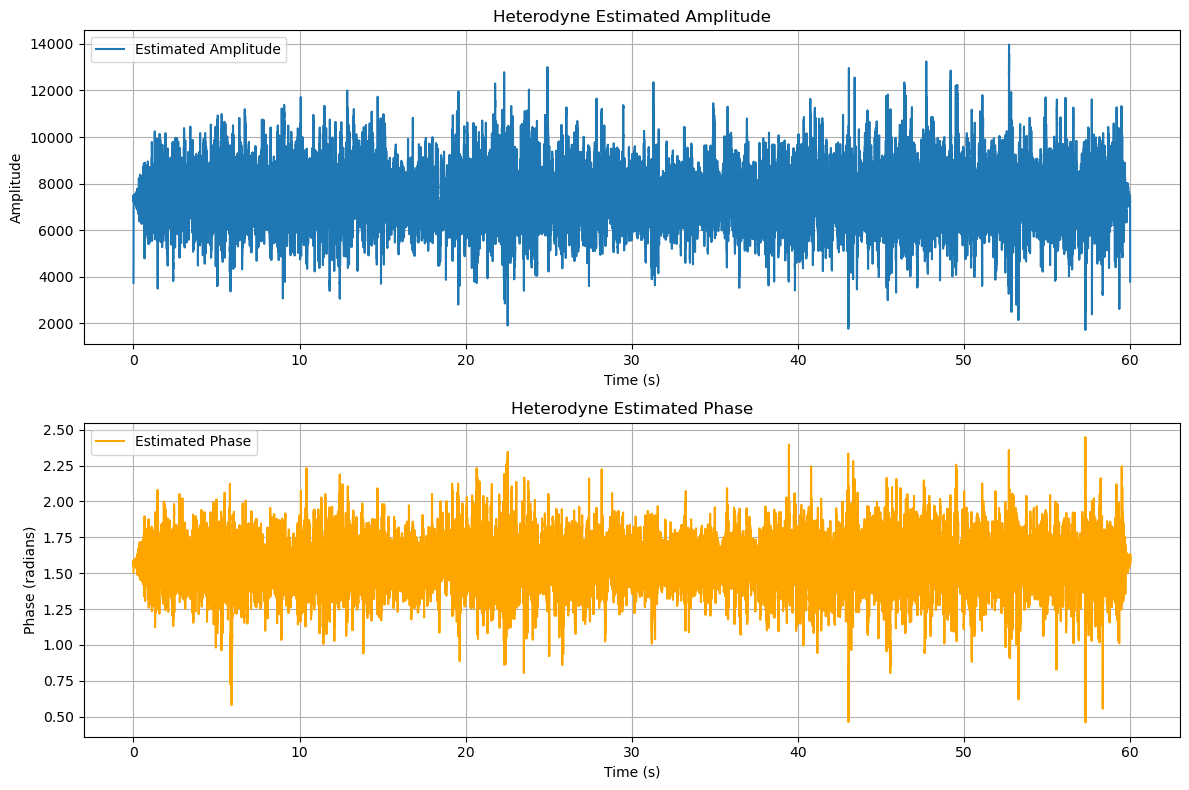

In [64]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, amplitude_est, label='Estimated Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Heterodyne Estimated Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, phase_est, label='Estimated Phase', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Phase (radians)')
plt.title('Heterodyne Estimated Phase')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()